# 数据栅格化

In [4]:
from pathlib import Path

import pandas as pd
import numpy as np

from utils.data_io import *

import rasterio as rio

In [5]:
data_path = Path("processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv")
data = get_csv(data_path)

print(data.columns)
print("\n-------------------------\n")
# 只选择需要的列
data = data[
    [
        "Time (sec)",
        "Delta Time (sec)",
        "Longitude (deg)",
        "UTM Easting (m)",
        "UTM Northing (m)",
        "Cross-Track (m)",
        "Along-Track (m)",
        "Height (m HAE)",
        "Height (m MSL)",
        "Solar Elevation (deg)",
        "point_type",
    ]
]

print(data.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time (sec)', 'Delta Time (sec)',
       'Segment ID', 'GT Num', 'Beam Num', 'Beam Type', 'Latitude (deg)',
       'Longitude (deg)', 'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone',
       'UTM Hemisphere', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Classification',
       'Signal Confidence', 'Solar Elevation (deg)', 'point_type', 'block'],
      dtype='object')

-------------------------

Index(['Time (sec)', 'Delta Time (sec)', 'Longitude (deg)', 'UTM Easting (m)',
       'UTM Northing (m)', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Solar Elevation (deg)',
       'point_type'],
      dtype='object')


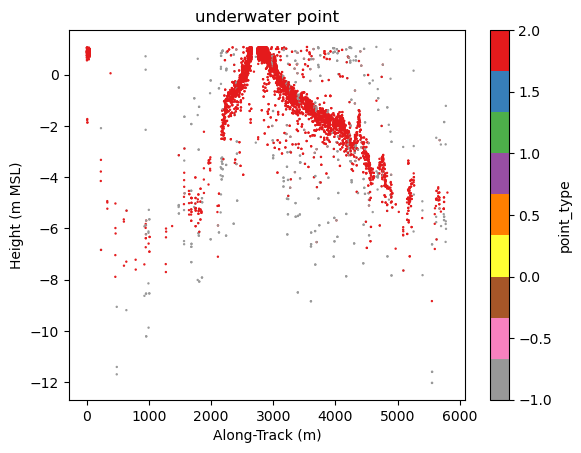

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'underwater point'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [6]:
from utils.denoise import PointType, get_normal_distribution
from utils.plot import get_plt

under_water_point = data.loc[data["point_type"] == PointType.LandSurface.value]

block = {}

for index, point in under_water_point.iterrows():
    id = point["Along-Track (m)"] // 10
    id = int(id)
    if id not in block:
        block[id] = []
    block[id].append(point)

new_ds = []
available_keys = sorted(list(block.keys()))
for id in available_keys:
    ds = pd.DataFrame(block[id])
    if (id + 1) in available_keys:
        # 如果块是连续的则扩展窗口
        ds = pd.concat([ds, pd.DataFrame(block[id + 1])])

    ds["point_type"] = PointType.LandSurface.value
    heights = ds["Height (m MSL)"].values
    mu, sigma = get_normal_distribution(heights)
    if sigma > 1:
        ds.loc[
            (ds["Height (m MSL)"] < mu - 0.5 * sigma)
            | (ds["Height (m MSL)"] > mu + 0.5 * sigma),
            "point_type",
        ] = PointType.Noise.value
    new_ds.append(ds)

seafloor_point = pd.concat(new_ds)

get_plt(
    seafloor_point, x="Along-Track (m)", y="Height (m MSL)", title="underwater point"
)

In [7]:
blocks = []
block_num = set()

for id in block.keys():
    ds = pd.DataFrame(block[id])
    ds = ds.loc[ds["point_type"] == PointType.LandSurface.value]
    block_num.add(len(ds))

    # icesat-2的激光点间隔是0.7m
    # 每个block大小是5m
    # 如果block的点数小于一定值，说明这个block是无效的


    if len(ds) < 2:
        continue
    else:
        blocks.append(id)
    
print(f"有效的block数量: {len(blocks)}")
print(f"block内可能的数量: {block_num}")

bs = []
tmp = []
for id in blocks:
    if len(tmp) < 1:
        tmp.append(id)
        continue

    if id - tmp[-1] == 1:
        tmp.append(id)
    else:
        bs.append(tmp)
        tmp = []
        tmp.append(id)

select_ids = max(bs, key=len)
print(f"最大连续block的数量: {len(select_ids)}")
print(f"最大连续block: {select_ids}")

有效的block数量: 311
block内可能的数量: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 36, 37, 38, 41, 42, 43, 44, 172, 45, 51, 52, 54, 189, 76, 87}
最大连续block的数量: 75
最大连续block: [275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]


In [8]:
from utils.anti_rasterization import get_keypoint

# 复制data.columns
key_points = pd.DataFrame(columns=data.columns)
for id in select_ids:
    ds = pd.DataFrame(block[id])
    kp = get_keypoint(ds).to_frame().T
    key_points = pd.concat([key_points, kp], ignore_index=True)

print(
    "key_points Along-Track (m):\n"
    + key_points["Along-Track (m)"][:10].to_string(index=False)
)
print(f"key_points数量: {len(key_points)}")

save_csv(key_points, "keypoints", tag="centers")

key_points Along-Track (m):
2755.718434
2767.936523
2770.093916
2789.517631
2795.274187
2800.310737
2816.134936
2829.071356
2835.534541
2841.993499
key_points数量: 75
keypoints_centers.csv already exists, will be overwritten!


C:\Users\natsuu\AppData\Local\Temp\ipykernel_87016\487077795.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  key_points = pd.concat([key_points, kp], ignore_index=True)


False

len of key_points: 75


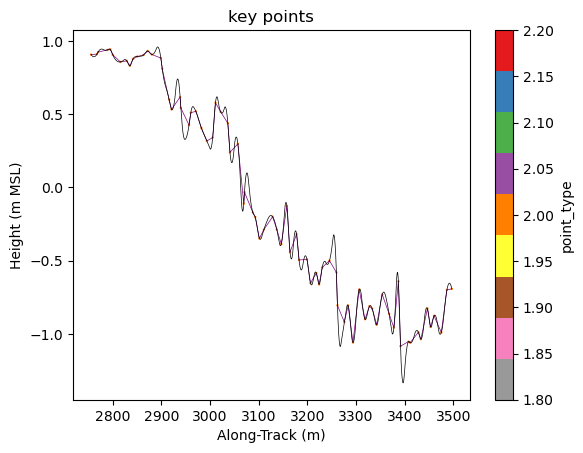

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'key points'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [9]:
print(f"len of key_points: {len(key_points)}")
get_plt(
    key_points,
    x="Along-Track (m)",
    y="Height (m MSL)",
    title="key points",
    curve=True,
    straight=True,
    k=2,
    bc_type="not-a-knot",
    interpolations=10000,
)